<a href="https://colab.research.google.com/github/mobinapourmoshir/Functional-Deep-Learning/blob/main/DNN%20Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Difference between Tensor data set and data loader

**Tensor:** just multi-dimensional arrays, like an extension of lists in Python.

**TensorDataset:** Imagine a data with features (input data) and labels (answers). TensorDataset pairs them together so you can access each input with its label. Combines multiple tensors (e.g., features X and labels y) into a dataset so that each sample can be accessed as a tuple (X[i], y[i]).

**DataLoader:** Provides an iterator over a dataset to feed data into a model in mini-batches. Handles batching, shuffling, and parallel loading automatically.

In [ ]:
##### Tensor #####
import torch

# 1D tensor
a = torch.tensor([1, 2, 3])
print(a)
print(a.shape)  # (3,)
print("--------")
# 2D tensor
b = torch.tensor([[1, 2], [3, 4]])
print(b)
print(b.shape)  # (2, 2)

tensor([1, 2, 3])
torch.Size([3])
--------
tensor([[1, 2],
        [3, 4]])
torch.Size([2, 2])


In [ ]:
##### Tensor Dataset #####
from torch.utils.data import TensorDataset

X = torch.tensor([[1,2], [3,4], [5,6]])  # features
y = torch.tensor([0, 1, 0])             # labels

dataset = TensorDataset(X, y)
print(dataset[0])

(tensor([1, 2]), tensor(0))


The DataLoader returns a different result each time because it shuffles the data and selects batches randomly during each iteration.

In [ ]:
##### DataLoaders #####
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=2, shuffle=True)

for batch_X, batch_y in loader:
    print("batch_X: ", batch_X)
    print("batch_y: ", batch_y)

batch_X:  tensor([[5, 6],
        [1, 2]])
batch_y:  tensor([0, 0])
batch_X:  tensor([[3, 4]])
batch_y:  tensor([1])


## **Implementing neural network on Iris data**

In [1]:
# Libraries
from sklearn.datasets import load_iris
import pandas as pd

In [2]:
# Load the Iris dataset
iris = load_iris()
print(iris.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


The loaded dataset is a Bunch object (scikit-learn datasets), which is similar to a dictionary. It contains:

- data: The feature matrix (sepal length, sepal width, petal length, petal width)
- target: The target labels (species of iris flower: 0, 1, 2)
- feature_names: Names of the features
- target_names: Names of the target classes (setosa, versicolor, virginica)
- DESCR: A description of the dataset

To convert it to a data frame using pandas:

In [3]:
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


In [11]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import random

In [14]:
# Set a seed number
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

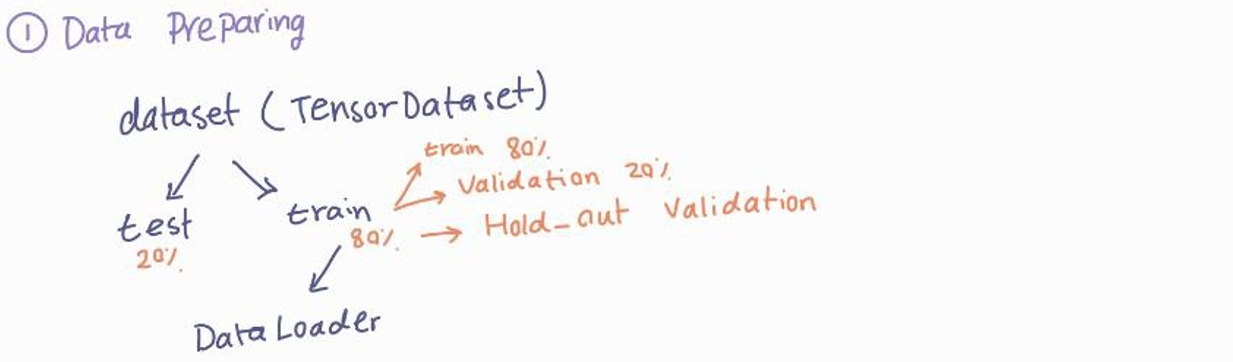

In [15]:
# 1. Data preparing
from sklearn import datasets
from torch.utils.data import TensorDataset
iris = datasets.load_iris()
X = iris.data # 150 x 4
y = iris.target # 150 with labels 0,1,2

# Test and train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)
# Standardize features (mean = 0, var =1)
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train) # Standardized
X_train_norm = torch.from_numpy(X_train_norm) # Converting it to torch
y_train = torch.from_numpy(y_train)

# TensorDataset
train_ds = TensorDataset(X_train_norm, y_train)
batch_size = 30

# DataLoader
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

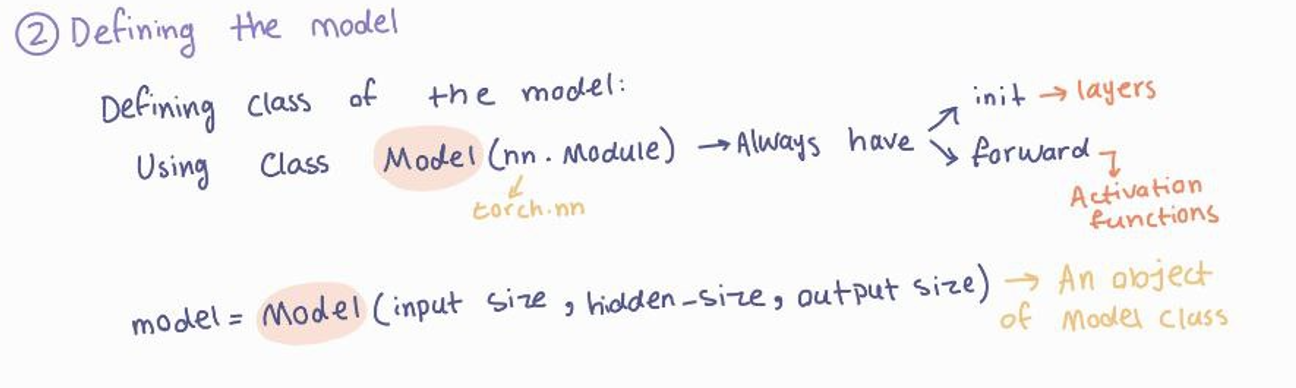

In [16]:
# The class of the model
class Model(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.layer1 = nn.Linear(input_size, hidden_size) # Layer 1
    self.layer2 = nn.Linear(hidden_size, output_size) # Layer 2
  def forward(self, x):
    x = self.layer1(x)
    x = nn.Sigmoid()(x) # sigmoid activation function for the first layer
    x = self.layer2(x)
    x = nn.Softmax(dim=1)(x) # softmax activation for the last (output) layer (softmax to support multiclass classification)
    return x

input_size = X_train_norm.shape[1]
hidden_size = 16 # Number of neurons in the hidden layer
output_size = 3

# object of the Model class:
model = Model(input_size, hidden_size, output_size)
model

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

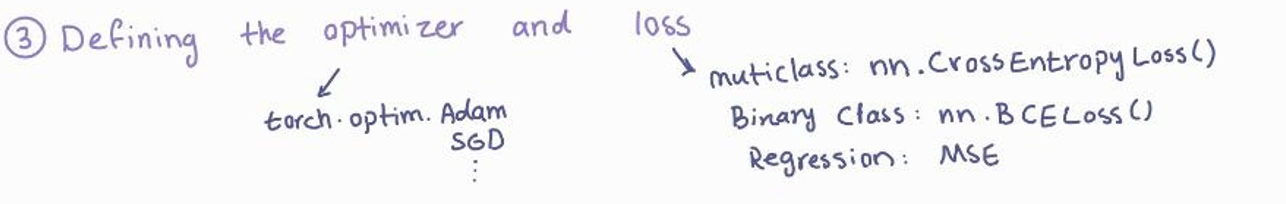

In [17]:
learning_rate = 0.001
# Loss function: CrossEntropyLoss: Works for multi-class classification. Minimizing this loss improves the model’s predicted probabilities for the correct classes.
loss_fn = nn.CrossEntropyLoss()
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)